$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{Universidad de los Andes}$$
$$\textrm{Grupo de Física de Altas Energías: Fenomenología de Partículas}$$

$\textbf{Preliminares}$ 

Las librerías que se usan en este capítulo son las siguientes: 

In [1]:
import os, sys

Path_Tutorials = os.path.dirname(os.path.realpath('Capitulo_3_Guardado_de_los_histogramas_en_un_archivo_root.ipynb'))
Path_Pheno_BSM = os.path.dirname(Path_Tutorials)
sys.path.append(Path_Pheno_BSM)

from ROOT import TH1F #Permite graficar los histogramas usando ROOT
from ROOT import TCanvas #Permite poner los histogramas
from ROOT import TFile #Permite guardar y leer los histogramas en un archivo .root

from delphes_reader import DelphesLoader 
from delphes_reader import root_analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output #Permite limpiar la línea del output para que no se imprima nada (es algo estético que se usa a veces) 
personal_folder = f'{Path_Pheno_BSM}/Tutorials'

Welcome to JupyROOT 6.26/06


$\textbf{Extraer las secciones eficaces}$

In [2]:
#Definamos una lista con las señales y un directorio para guardar las secciones eficaces:

signals = ["z", "w_jets", "ww", "wz", "zz", "ttbar", "stop"]
XS = {}

#XS de señal:
tabla_ij = pd.read_html(f'{personal_folder}/Data_Z/crossx.html')
columna_xs = tabla_ij[0]['Cross section (pb)']
XS['z'] = float(columna_xs[0].split(' ')[0])    

#XS de backgrounds:
BKGs = ["w_jets", "ww", "wz", "zz", "ttbar", "stop"]

for BKG in BKGs:
    Delphes_Process = DelphesLoader(BKG) #Se crea un objeto de la clase DelphesLoader correspondiente al proceso BKG
    XS[BKG] = float(Delphes_Process.xs) #Extrae la sección eficaz del BKG -  esta en pb
clear_output(wait=False)

Así, XS es un directorio con la sección eficaz de cada proceso, esto nos servirá más adelante para normalizar los histogramas según el número de eventos.

In [3]:
XS #Están en pb

{'z': 637.2,
 'w_jets': 146548.3,
 'ww': 65.50736,
 'wz': 24.69184,
 'zz': 9.562416,
 'ttbar': 504.696,
 'stop': 241.17}

$\textbf{Leer los datos de los archivos .csv}$

In [4]:
Datasets_muon0 = {}
Datasets_muon1 = {}
Datasets_correlation = {}
Datasets_Z = {}

for signal in signals:
    Datasets_muon0[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_muon0/{signal}.csv')
    del Datasets_muon0[signal][Datasets_muon0[signal].columns[0]] #Borra una columna de ceros que aparecia sin esto
    Datasets_muon1[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_muon1/{signal}.csv')
    del Datasets_muon1[signal][Datasets_muon1[signal].columns[0]]
    Datasets_correlation[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_correlation/{signal}.csv')
    del Datasets_correlation[signal][Datasets_correlation[signal].columns[0]]
    Datasets_Z[signal] = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/Data_Z/{signal}.csv')
    del Datasets_Z[signal][Datasets_Z[signal].columns[0]]

cut_flows = pd.read_csv(f'{personal_folder}/CSV_Z_Analisis/cut_flows.csv',index_col = 0)

Así, tenemos un diccionario para los datasets de cada señal:

In [5]:
Datasets_muon0.keys() 

dict_keys(['z', 'w_jets', 'ww', 'wz', 'zz', 'ttbar', 'stop'])

Usando esas keys podemos acceder al que necesitemos:

**Por ejemplo**:

In [6]:
Datasets_muon0['z']

,pT_{#mu}(GeV),#eta_{#mu},#phi_{#mu},Energy_{#mu}(GeV),Mass_{#mu}(GeV)
0,41.667759,-1.589091,1.830774,106.323796,0.105658
1,49.013069,2.201596,3.011407,224.236178,0.105658
2,48.903419,-0.755841,-1.702463,63.550515,0.105658
3,40.123135,1.927982,-3.041330,140.853621,0.105658
4,39.876068,0.629823,-0.791555,48.050070,0.105658
...,...,...,...,...,...
183575,62.217964,0.448784,-2.960287,68.589473,0.105658
183576,51.748001,-0.741654,0.322956,66.644530,0.105658
183577,61.150513,-1.181462,-2.142098,109.030373,0.105658
183578,45.233368,-1.480476,0.059437,104.547205,0.105658


$\textbf{Creación de los Histogramas}$

En este paso la idea es usar todos los datos para construir los histogramas que sean de nuestro interés y guardarlos todos en un archivo .root; sin embargo, antes de guardarlos en un archivo.root hagamos un par para practicar.

Una opción para graficar puede ser usar matplotlib.pyplot

In [7]:
def Histogramas_Matplotlib(Dataset, signal, name, log = False, c = 'blue'):
    Datos = Dataset[signal][name]
    if log: Datos = np.log10(Datos)
    
    fig = plt.figure(figsize = (6,4))
    plt.hist(Datos, bins= 100, color = c, density=True)
    
    name = '$' + name.replace('#' , "\\" ) + '$'
    plt.xlabel(fr'{name}', fontsize = 15)
    plt.ylabel('Events', fontsize = 15)
    
    titulo = 'Mean = ' + str(round(Datos.mean(),3))+ ", STD = " + str(round(Datos.std(),3))
    plt.title(titulo)
    plt.show()

Usando esta función es más fácil graficar todas las variables de una vez, tomemos como ejemplo el Z que reconstruimos.

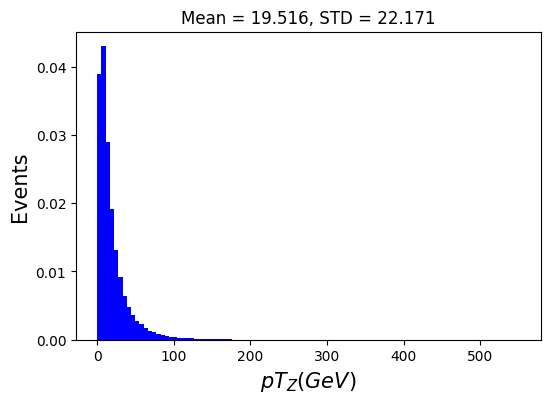

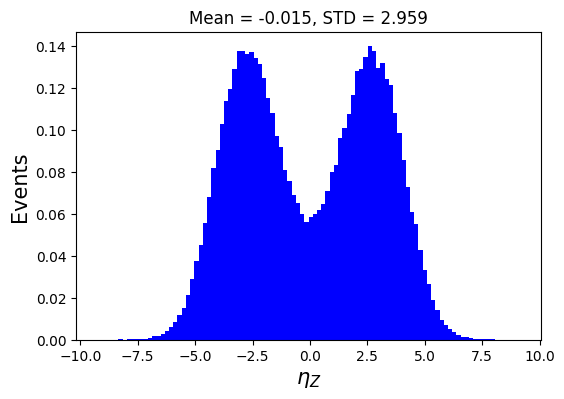

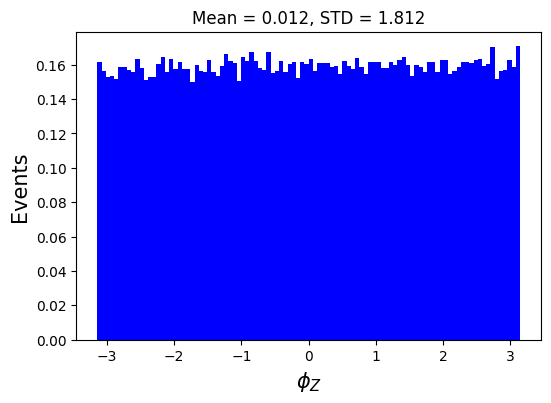

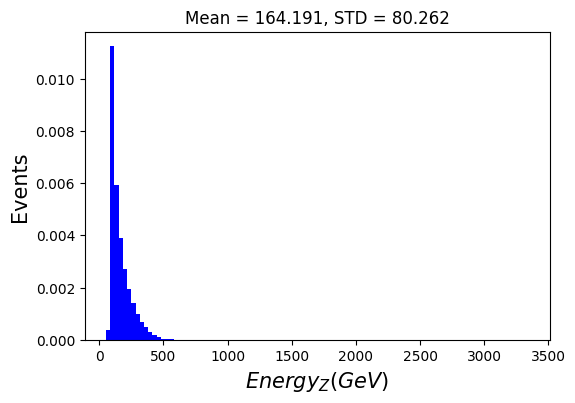

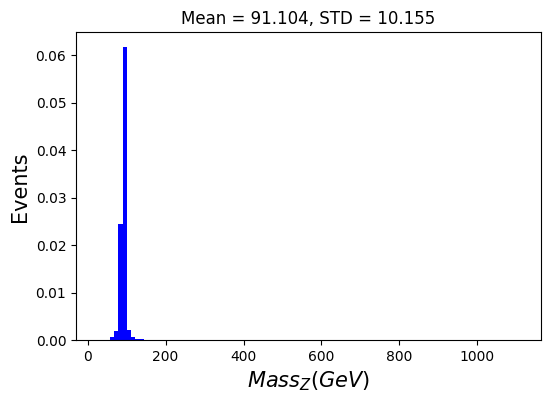

In [8]:
for signal in signals:
    for name in Datasets_Z[signal].keys():
        Histogramas_Matplotlib(Datasets_Z,signal, name, c = "blue")
    break

Aunque esta es bastante sencilla de usar dentro del jupyter, no nos permite guardar los histogramas en un archivo.root (ese será el paso 7), para esto, es necesario que grafiquemos usando ROOT, lo cual podría parecer más complicado; sin embargo, ya está implementado en delphes_reader:

In [9]:
#Para eso debemos primero crear un diccionario donde cada elemento significa los valores [nbins,xmin,xmax] del histograma correspondiente

histogramas_bins_dict={
    "#Delta{R}":[8,0,7],
    "#Delta{#eta}":[20,-5,5],
    "#Delta{#phi}":[13,-3.25,3.25],
    "#Delta{pt}":[15, 0.0, 1500.0],
    "#Delta{#vec{pT}}":[30, 0.0, 3000.0],
    "#Delta{#vec{p}}":[30, 0.0, 3000.0],
    "MET(GeV)":[20, 0.0, 1000.0],
    "pT_": [100,0, 180],
    "#eta_":[20, -5, 5],
    "#phi_":[64, -3.2, 3.2],
    "Mass_":[167, 0.0, 250],
    "Energy_":[20, 0.0, 1000.0]
}

#Ahora simplemente usamos la función make_histograms e hist_bins_dict como parametro
histogramas = root_analysis.make_histograms(Datasets_Z['z'], hist_bins_dict = histogramas_bins_dict)

Así, histogramas será un diccionario que contiene todos los TH1F de root, para graficar el que queramos simplemente hay que usar sus keys:

In [10]:
histogramas.keys()

dict_keys(['pT_{Z}(GeV)', '#eta_{Z}', '#phi_{Z}', 'Energy_{Z}(GeV)', 'Mass_{Z}(GeV)'])

Y crear un canvas:

In [11]:
canvas = TCanvas("Canvas", " ", 600, 400)

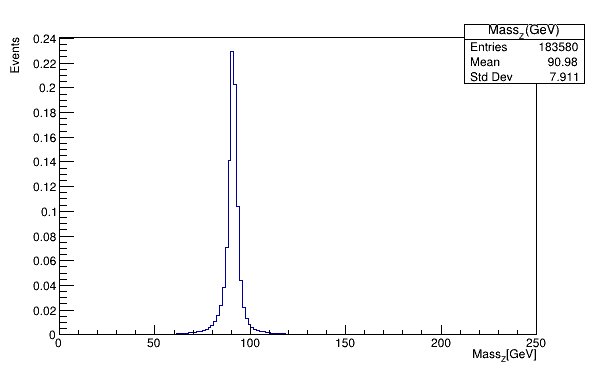

In [12]:
histogramas['Mass_{Z}(GeV)'].Draw('hist')
canvas.Draw()

Estos histogramas salen de **make_histograms** normalizados según la unidad; sin embargo, los necesitamos normalizados según el número de eventos físicos (N), donde:

$$\textbf{N} \textrm{ = Luminosidad*Eficiencia*XS}$$ 

Con: $$\textrm{Luminosidad} = 10 \textrm{ fb} \textrm{ , } \textrm{Eficiencia} = \cfrac{\textrm{Número de Eventos Finales}}{\textrm{Número de Eventos Iniciales}}$$

Para calcular la eficiencia debemos cargar el archivo de cut_flows que generamos anteriormente.

In [13]:
#Definamos una función que calcule la eficiencia leyendo el archivo cut_flows

def Eficiencia(signal, Path_CSV, fila = -1, cut_flows_actualizado = False):
    #fila corresponde a la fila respecto a la cual se va a calcular la Eficiencia relativa, por default es -1 ya que corresponde al último corte

    cut_flows = pd.read_csv(f'{Path_CSV}/CSV_Z_Analisis/cut_flows.csv')
    if cut_flows_actualizado: cut_flows = pd.read_csv(f'{Path_CSV}/CSV_Z_Analisis/cut_flows_actualizado.csv')
    
    cut_flows_signal = np.asarray(cut_flows[signal])
    Eficiencia = cut_flows_signal[fila]/cut_flows_signal[0]
    
    return Eficiencia

#Tambien definamos la Luminosidad

def Luminosidad():
    return 10*1000 #pb

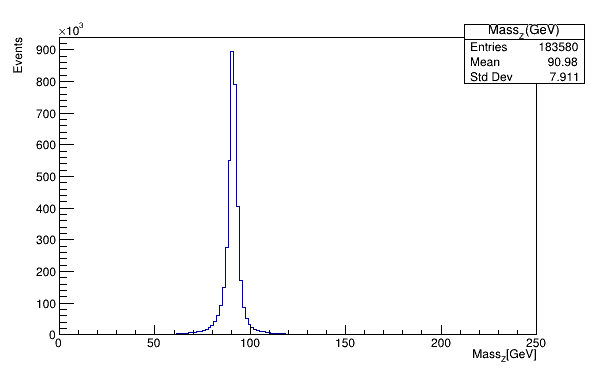

In [14]:
N = Eficiencia('z', Path_CSV = personal_folder)*Luminosidad()*XS['z']

#Ahora si normalicemos usando este N el histograma
histogramas['Mass_{Z}(GeV)'].Scale(N/histogramas['Mass_{Z}(GeV)'].Integral())
histogramas['Mass_{Z}(GeV)'].Draw('hist')
canvas.Draw()

En este punto tenemos el histograma normalizado según el número de eventos. Ahora la idea es hacer esto para generar los histogramas de todas las señales y guardarlos.

In [15]:
#Creemos diccionarios para guardar los Histogramas de cada Dataset:
histogramas_muon0 = {}
histogramas_muon1 = {}
histogramas_correlation = {}
histogramas_Z = {}

for signal in signals:
    histogramas_muon0[signal] = root_analysis.make_histograms(Datasets_muon0[signal], hist_bins_dict = histogramas_bins_dict)
    histogramas_muon1[signal] = root_analysis.make_histograms(Datasets_muon1[signal], hist_bins_dict = histogramas_bins_dict)
    histogramas_correlation[signal] = root_analysis.make_histograms(Datasets_correlation[signal], hist_bins_dict = histogramas_bins_dict)
    histogramas_Z[signal] = root_analysis.make_histograms(Datasets_Z[signal], hist_bins_dict = histogramas_bins_dict)    
    
#De hecho podemos guardar todos estos en otro diccionario:
histogramas = {'muon0': histogramas_muon0, 'muon1': histogramas_muon1, 'correlation': histogramas_correlation, 'Z': histogramas_Z}

#Delta{pT}_{#mu#mu}(GeV)  is empty!


Así, histogramas va a tener la siguiente forma:

In [16]:
histogramas #Es un directorio de particulas de directorios de las señales de directorios de las variables cinematicas

{'muon0': {'z': {'pT_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53efe00b0>,
   '#eta_{#mu}': <cppyy.gbl.TH1F object at 0x55b53ef7aaa0>,
   '#phi_{#mu}': <cppyy.gbl.TH1F object at 0x55b537ee22e0>,
   'Energy_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b537ee1ef0>,
   'Mass_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53f28c600>},
  'w_jets': {'pT_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53f2ebf50>,
   '#eta_{#mu}': <cppyy.gbl.TH1F object at 0x55b53f2ec420>,
   '#phi_{#mu}': <cppyy.gbl.TH1F object at 0x55b53f2c3b90>,
   'Energy_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53f2c4140>,
   'Mass_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53f2a9f80>},
  'ww': {'pT_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53f2d63e0>,
   '#eta_{#mu}': <cppyy.gbl.TH1F object at 0x55b53f308ae0>,
   '#phi_{#mu}': <cppyy.gbl.TH1F object at 0x55b53f2eb0f0>,
   'Energy_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53f2e0420>,
   'Mass_{#mu}(GeV)': <cppyy.gbl.TH1F object at 0x55b53f2e6e10>},
  'wz': {'pT_{#mu}(GeV

Así si queremos graficar por ejemplo ETA del muon1 de la señal WW simplemente hay que hacer el siguiente código:

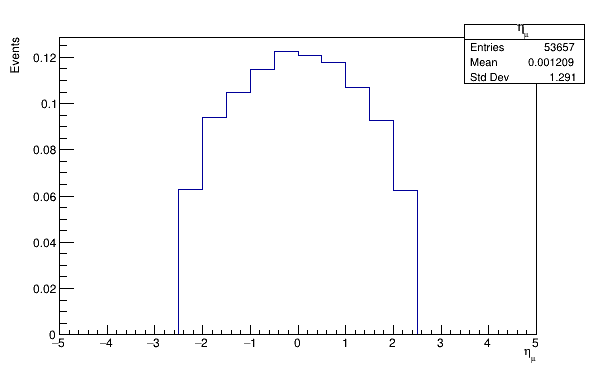

In [17]:
histogramas['muon1']['ww']['#eta_{#mu}'].Draw('hist')
canvas.Draw()

Sin embargo, aún nos falta normalizarlos según el número de eventos, hagámoslo:

In [18]:
for nombre in histogramas:
    for signal in signals:
        N = Eficiencia(signal, Path_CSV = personal_folder)*Luminosidad()*XS[signal]
        histos = histogramas[nombre][signal]
        for hist in histos:
            h = histos[hist]
            h.Scale(N/h.Integral())

/tmp/ipykernel_3050/975106596.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  h.Scale(N/h.Integral())


Así, si volvemos a tratar de graficar el que usamos como ejemplo, veremos que efectivamente su escala cambio:

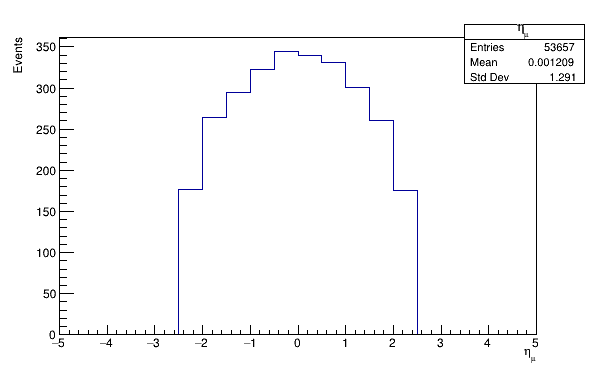

In [19]:
histogramas['muon1']['ww']['#eta_{#mu}'].Draw('hist')
canvas.Draw()

Estos histogramas normalizados según su número de eventos son los que debemos guardar en el archivo.root

$\textbf{Creación del archivo.root con los Histogramas}$

Este paso variara según el análisis que se quiera hacer y también la estructura que queramos tener en el archivo.root; sin embargo, supongammos que tenemos un histograma (objeto TH1F) llamado hist y queremos guardarlo en un archivo llamado ejemplo.root dentro de una carpeta llamada carpeta, el código a escribir se vuelve simplemente lo siguiente:

In [20]:
#Para este ejemplo tomemos hist como el histograma que graficamos arriba, el de la masa del Z reconstruida de la señal zz, es decir:
hist = histogramas_Z['z']['Mass_{Z}(GeV)']

#Con esto en mente, ahora debemos crear el archivo.root
rootFile = TFile.Open("ejemplo.root", "RECREATE")

carpeta = rootFile.mkdir("carpeta") #Creación de la carpeta llamada "carpeta"
carpeta.cd() #Abre uno esa carpeta para trabajar en ella, esto permite que podamos guardar los histogramas en ella más adelante.

hist.Write("Histograma") #Se guarda el histograma dentro de la ruta en que estemos (la que corresponda al último cd, en este caso es dentro de carpeta) bajo el nombre Histograma, saber el nombre es importante para poder leer el archivo.root más adelante y tratar de extraer el histograma.
        
rootFile.Close()#Se cierra el archivo.root

Este razonamiento se puede complificar tanto como se requiera, en este caso la estructura que se puede pensar para este análisis cinemática en el archivo.root es la siguiente: 

Dentro del archivo.root tendremos una carpeta para cada Dataset (Datasets_muon0, Datasets_muon1, etc), luego dentro de cada una de esas carpetas habrá otra carpeta para cada señal (z, zz, wz, wjets, etc). Finalmente, en dichas carpetas estarán los histogramas correspondientes. 

Es decir que el histograma de pT que está en la ruta: archivo.root/muon0/zz/ corresponderá al histograma del PT del muon 0 del proceso zz. 

Siguiendo este razonamiento se puede definir la siguiente función para facilitar la creación del archivo.root 

In [21]:
def Write_ROOT_File(nombre, Histogramas, signals):
    #nombre: Es el nombre que queremos que tenga el archivo.root
    #Histogramas: Es un diccionario que debe tener una estructura analoga a: histogramas = {'muon': histogramas_muon0, 'muon1': histogramas_muon1, 'correlation': histogramas_correlation, 'Z': histogramas_Z}
    #signals: Arreglo con los nombres de las subcarpetas que crear, en este caso corresponden a los keys de Paths debido a que así planteamos la estructura en la que queremos guardar el archivo
    
    ROOT_File = TFile.Open(nombre, 'RECREATE') #Crea el archivo .root
    
    for nombre in Histogramas.keys():
        dir_carpeta = ROOT_File.mkdir(nombre) #Creación de la carpeta con el contendra todos los histogramas para todos los procesos correspondientes a la particual con el nombre de dicha carpeta, dígamos, si la carpeta se llama muon0 todo corresponde al muon0
        dir_carpeta.cd() #Abre uno esa carpeta para trabajar en ella, esto permite que podamos guardar los histogramas en ella más adelante.
        
        histogramas_particula = Histogramas[nombre]
        
        for signal in signals: 
            dir_signal = dir_carpeta.mkdir(signal) #Crea la subcarpeta de la señal.
            dir_signal.cd() #Abre la subcarpeta de la señal.

            for hist in histogramas_particula[signal]:
                histogramas_particula[signal][hist].Write() #Se guarda el histograma en la ruta deseada, con el nombre de la carpeta, la señal y el nombre que tenía, esto facilitara buscarlos despues
    
    ROOT_File.Close()#Se cierra el archivo.root
    
    !touch archivo_root_generado.txt #Testigo para saber cuando acabo de correr el código anterior.

In [22]:
Write_ROOT_File("Histogramas.root", histogramas,  signals)

En este punto ya tendremos el archivo.root con todos los histogramas que se necesitan, por lo que es posible leerlo cuando se desee trabajar con ellos, ese será el tema del siguiente capítulo.